In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['text.usetex']= True

### PCA

In [3]:
# Generate dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca_inv = pca.inverse_transform(X_pca)
X_pca[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

Let's try to implement PCA! Suppose the singular value decomposition of $\mathbf{X}$ is $\mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\mathsf{T}}$. Since $\mathbf{U}$ and $\mathbf{V}$ are unitary, we have $\mathbf{X}^{\mathsf{T}} \mathbf{X} = \mathbf{V}\hat{\mathbf{\Sigma}}^2\mathbf{V}^{\mathsf{T}}$ where $\hat{\mathbf{\Sigma}}$ is the square root of $\mathbf{\Sigma}^{\mathsf{T}} \mathbf{\Sigma}$. Comparison with the eigendecomposition of $\mathbf{X}^{\mathsf{T}} \mathbf{X}$ implies that the columns of $\mathbf{V}$ are the eigenvectors of $\mathbf{X}^{\mathsf{T}} \mathbf{X}$.

The transformed data is given by $\mathbf{X}\mathbf{V}$, and we can truncate last columns of $\mathbf{V}$ to do dimensionality reduction. To convert the data back to the space of $\mathbf{X}$, simply multiple on the right with $\mathbf{V}^{\mathsf{T}}$.

In [5]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
assert(np.allclose(X_centered, (U * s).dot(Vt)))
X_svd = X_centered.dot(Vt.T[:, :2])
# PCA is up to sign
assert(np.allclose(X_pca, -X_svd))
X_svd_inv = X_svd.dot(Vt[:2, :])
# PCA automatically reserves the mean centering
assert(np.allclose(X_svd_inv + X.mean(axis=0), X_pca_inv))
X_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [6]:
# Reconstruction error
np.mean(np.sum(np.square(X_pca_inv - X), axis=1))

0.01017033779284855

The PCA components are just rows of $\mathbf{V}^{\mathsf{T}}$, i.e. columns of $\mathbf{V}$. The signs are flipped, as expected.

In [7]:
print(pca.components_)
print(Vt[:2])

[[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]]
[[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]]


Here's how the explained variance ratio computed:

In [8]:
print(pca.explained_variance_ratio_)
print(np.square(s[:2]) / np.sum(np.square(s)))

[ 0.84248607  0.14631839]
[ 0.84248607  0.14631839]


Let's add some visualization!

In [9]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

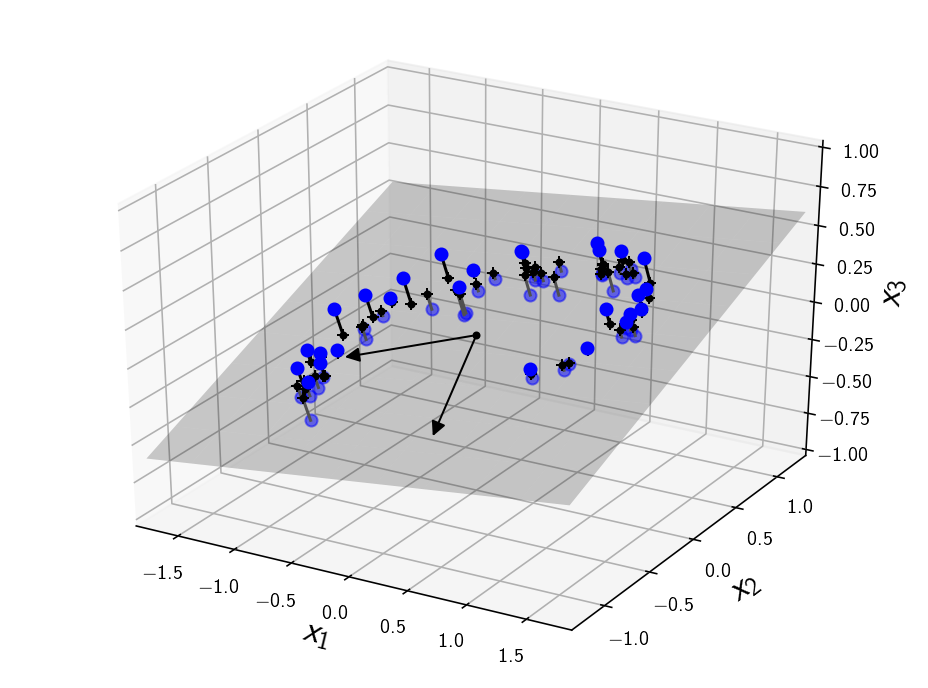

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X_pca_inv[:, 2]]
X3D_below = X[X[:, 2] <= X_pca_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X_pca_inv[i, 2]:
        ax.plot([X[i][0], X_pca_inv[i][0]], [X[i][1], X_pca_inv[i][1]], [X[i][2], X_pca_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X_pca_inv[i][0]], [X[i][1], X_pca_inv[i][1]], [X[i][2], X_pca_inv[i][2]], "k-", color="#505050")
    
ax.plot(X_pca_inv[:, 0], X_pca_inv[:, 1], X_pca_inv[:, 2], "k+")
ax.plot(X_pca_inv[:, 0], X_pca_inv[:, 1], X_pca_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

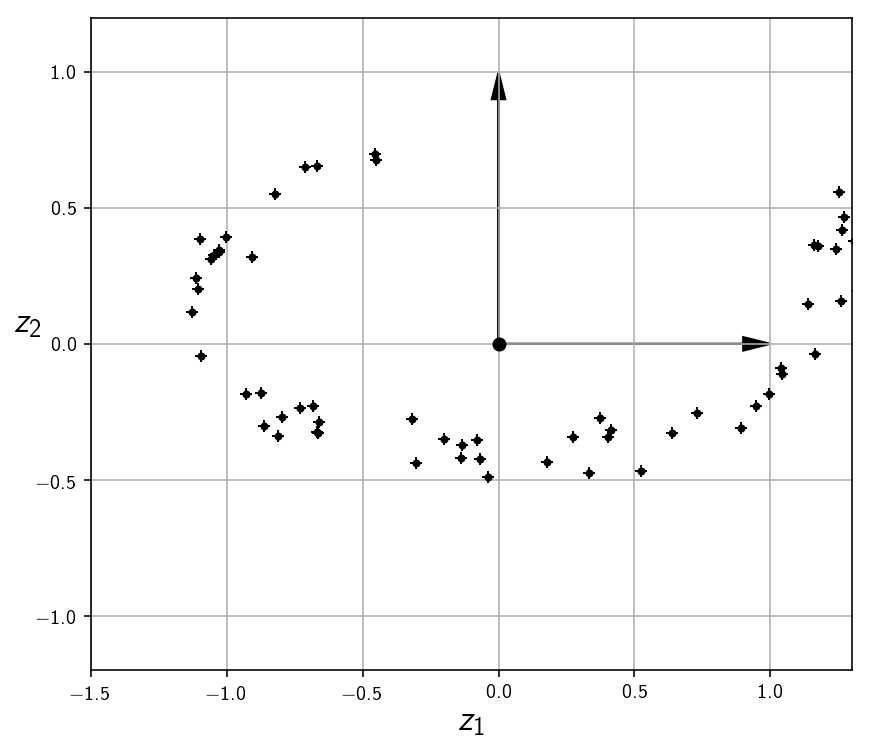

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X_pca[:, 0], X_pca[:, 1], "k+")
ax.plot(X_pca[:, 0], X_pca[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

### Manifold Learning

In [12]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

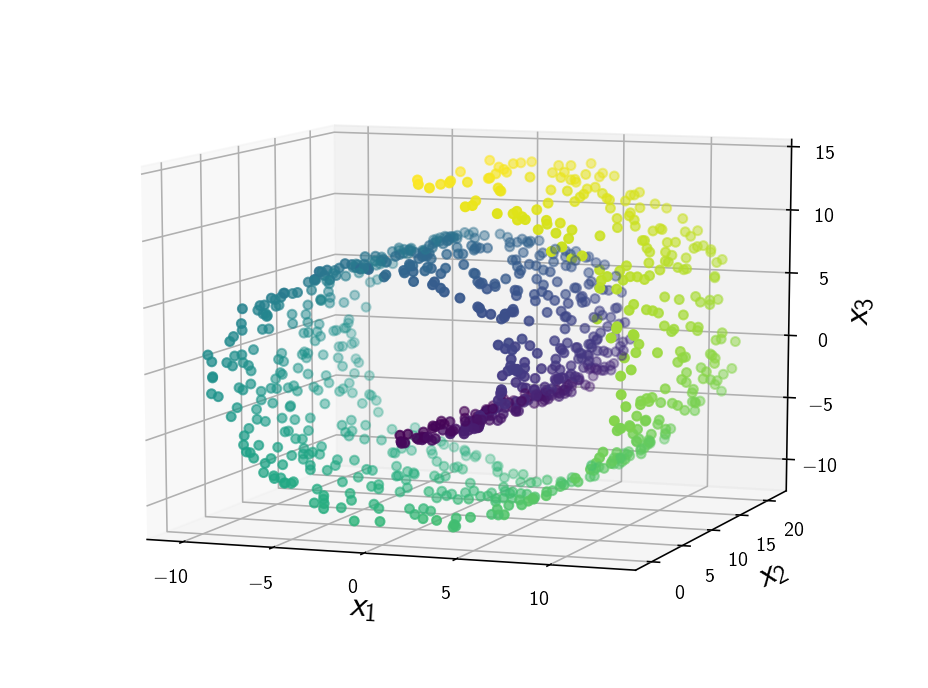

In [13]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

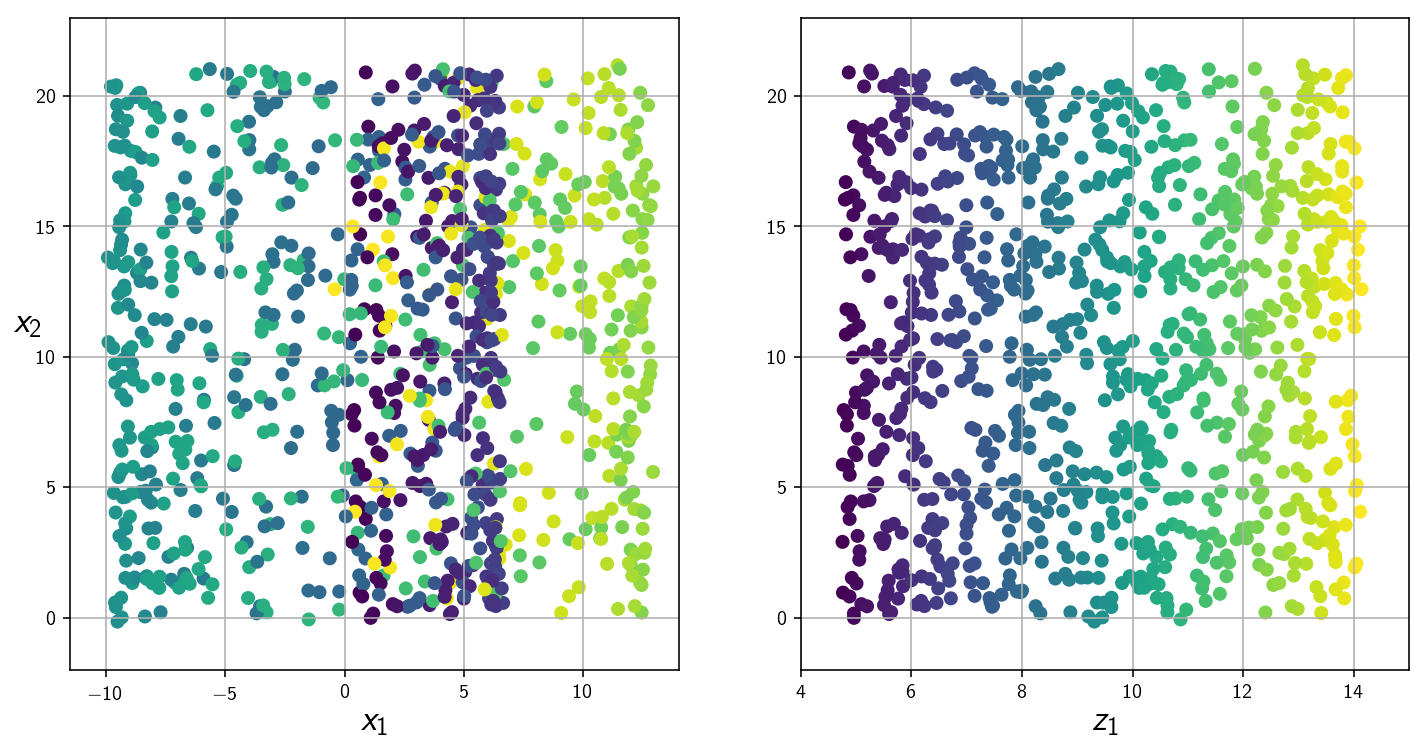

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

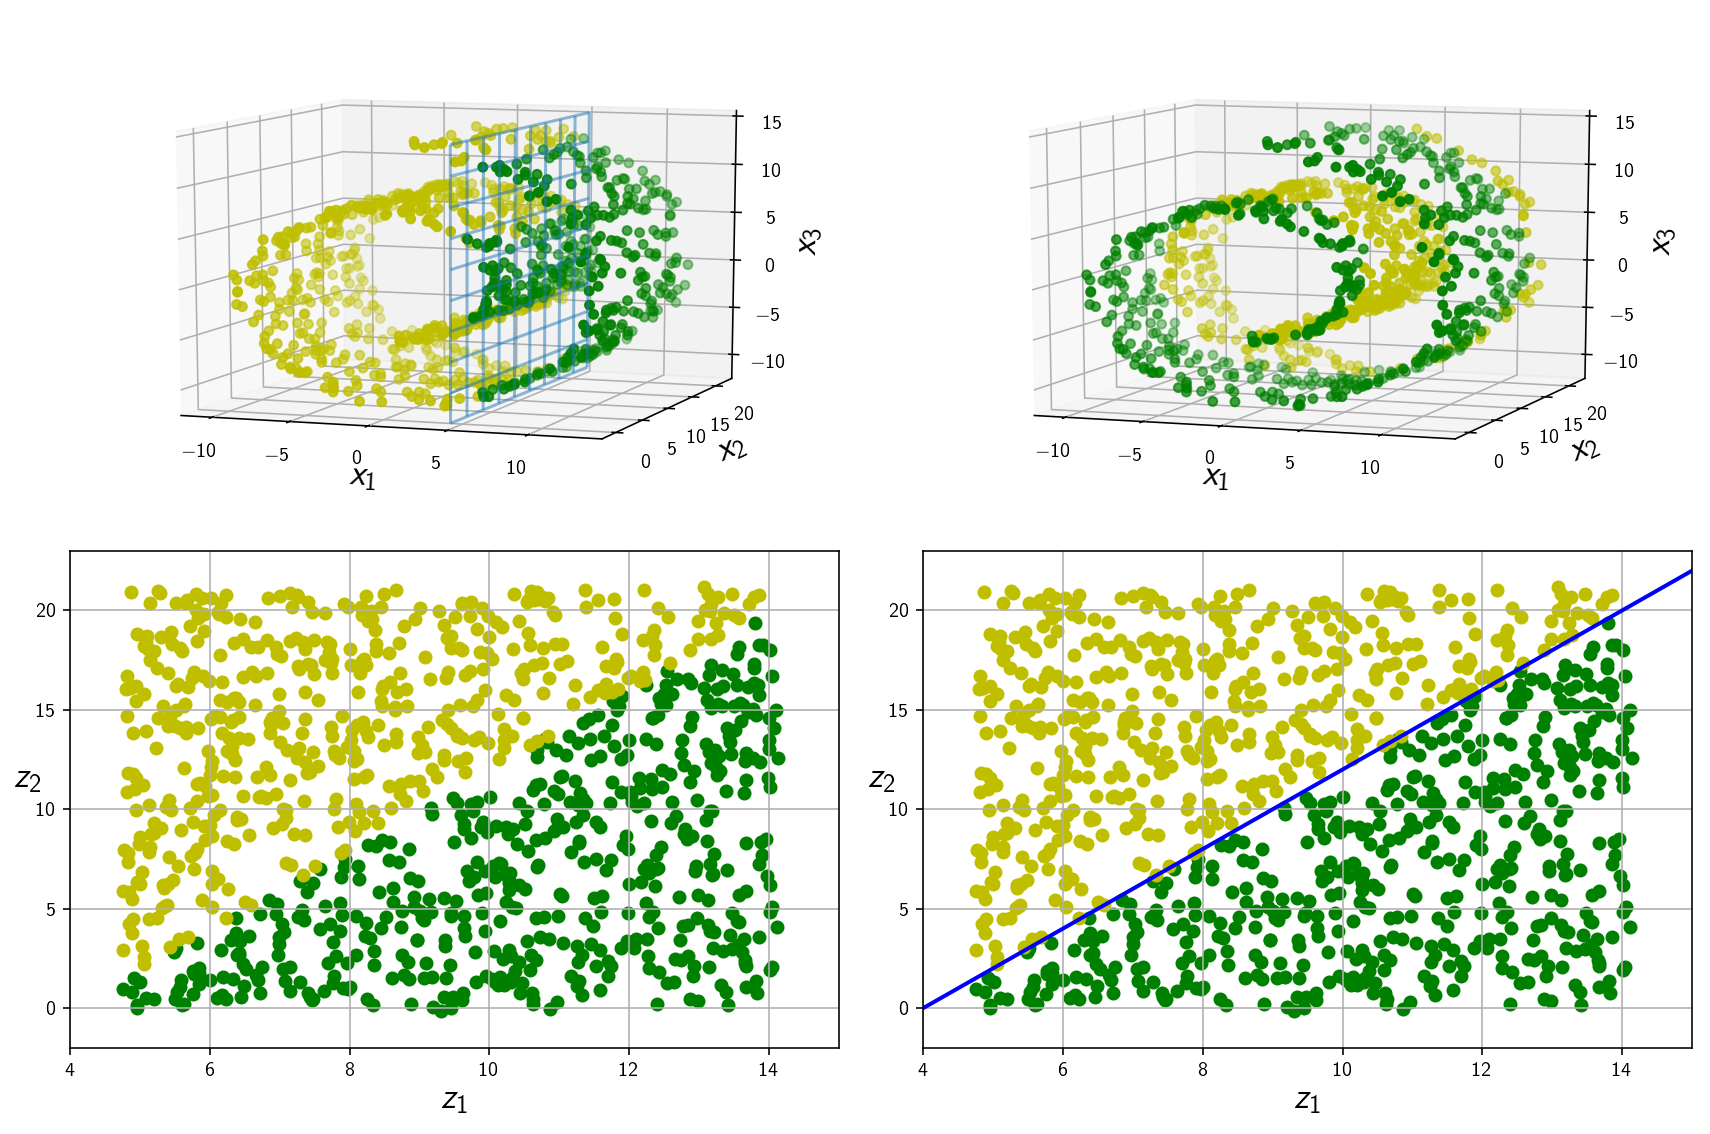

In [15]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(221, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.scatter(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], c="y")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.scatter(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], c="g")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

ax = fig.add_subplot(222, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.scatter(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], c="y")
ax.scatter(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], c="g")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

ax = fig.add_subplot(223)

plt.scatter(t[positive_class], X[positive_class, 1], c="g")
plt.scatter(t[~positive_class], X[~positive_class, 1], c="y")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

ax = fig.add_subplot(224)

plt.scatter(t[positive_class], X[positive_class, 1], c="g")
plt.scatter(t[~positive_class], X[~positive_class, 1], c="y")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.tight_layout()

### MNIST Compression

In [16]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [17]:
from sklearn.model_selection import train_test_split
X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_train)
X_pca_inv = pca.inverse_transform(X_pca)

In [19]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap='gray', **options)
    plt.axis("off")

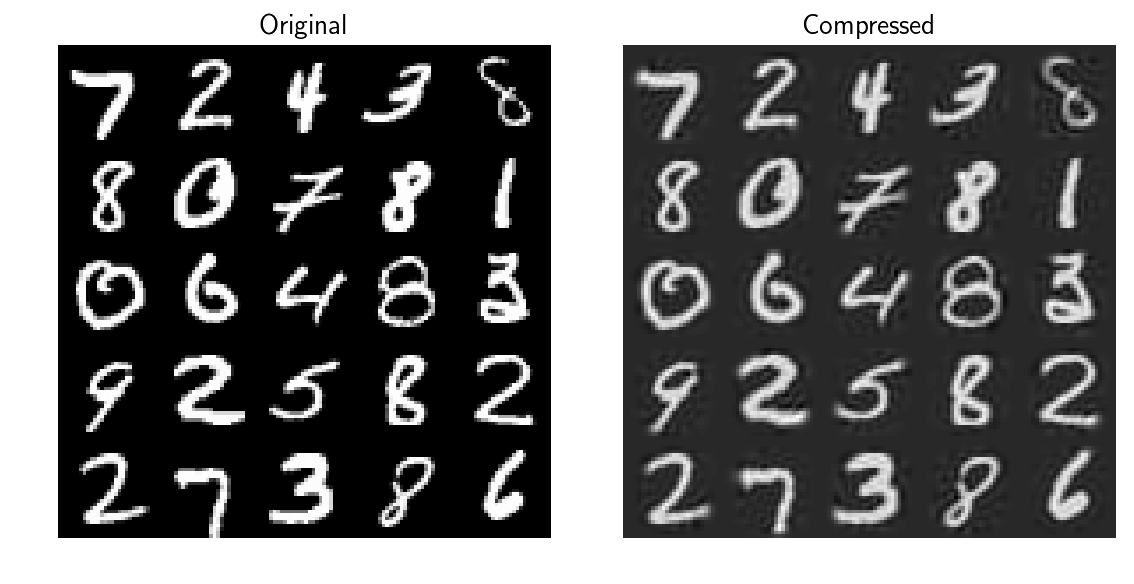

In [20]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=14)
plt.subplot(122)
plot_digits(X_pca_inv[::2100])
plt.title("Compressed", fontsize=14)
plt.tight_layout()

### Incremental PCA

In [21]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_inc_pca = inc_pca.transform(X_train)
X_inc_pca_inv = inc_pca.inverse_transform(X_inc_pca)

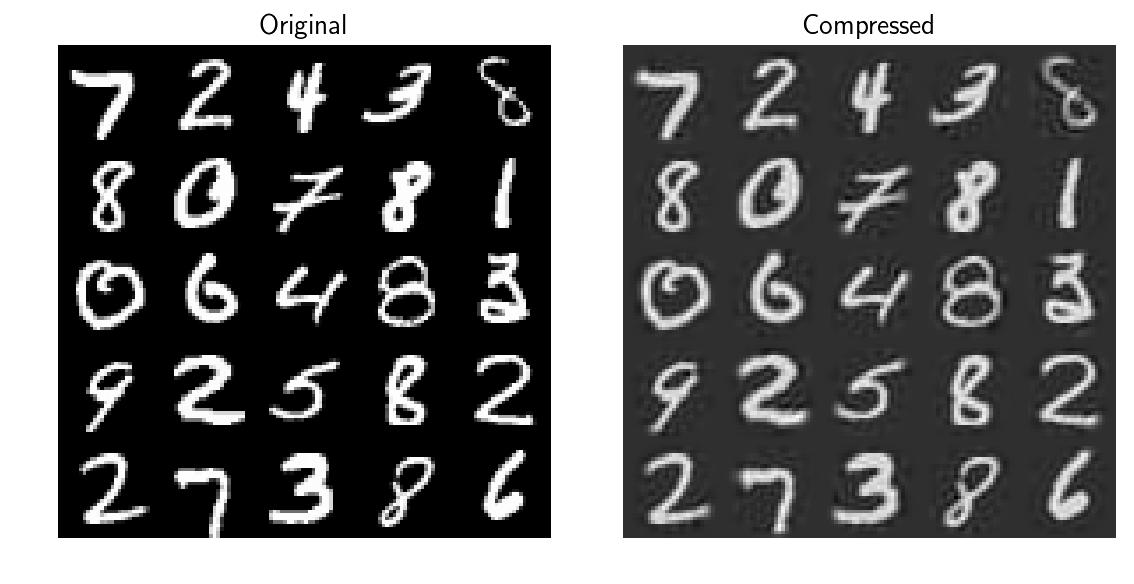

In [22]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=14)
plt.subplot(122)
plot_digits(X_inc_pca_inv[::2100])
plt.title("Compressed", fontsize=14)
plt.tight_layout()

In [23]:
np.allclose(pca.mean_, inc_pca.mean_), np.allclose(X_pca_inv, X_inc_pca_inv)

(True, False)

### Time Complexity

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [24]:
import time

for n_components in (2, 10, 154):
    print("number of components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.4f} seconds".format(pca.__class__.__name__, t2 - t1))

number of components = 2
    PCA: 1.9462 seconds
    IncrementalPCA: 10.5550 seconds
    PCA: 1.8178 seconds
number of components = 10
    PCA: 2.0550 seconds
    IncrementalPCA: 11.5691 seconds
    PCA: 1.9852 seconds
number of components = 154
    PCA: 5.1301 seconds
    IncrementalPCA: 15.5222 seconds
    PCA: 5.2315 seconds


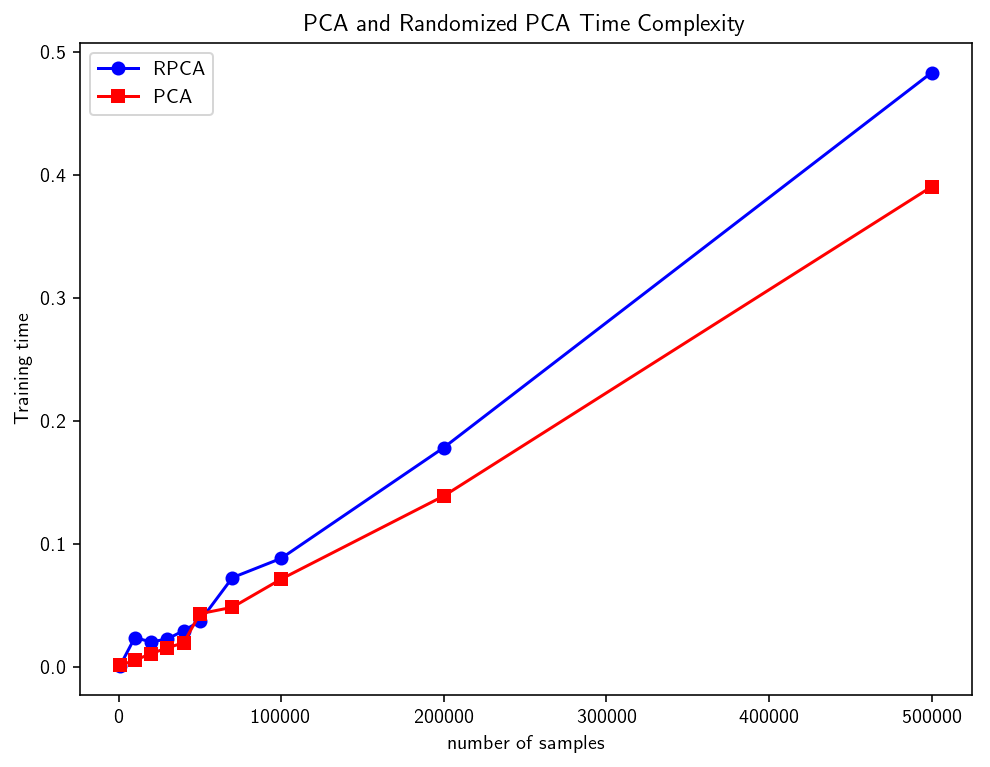

In [25]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("number of samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA Time Complexity ");

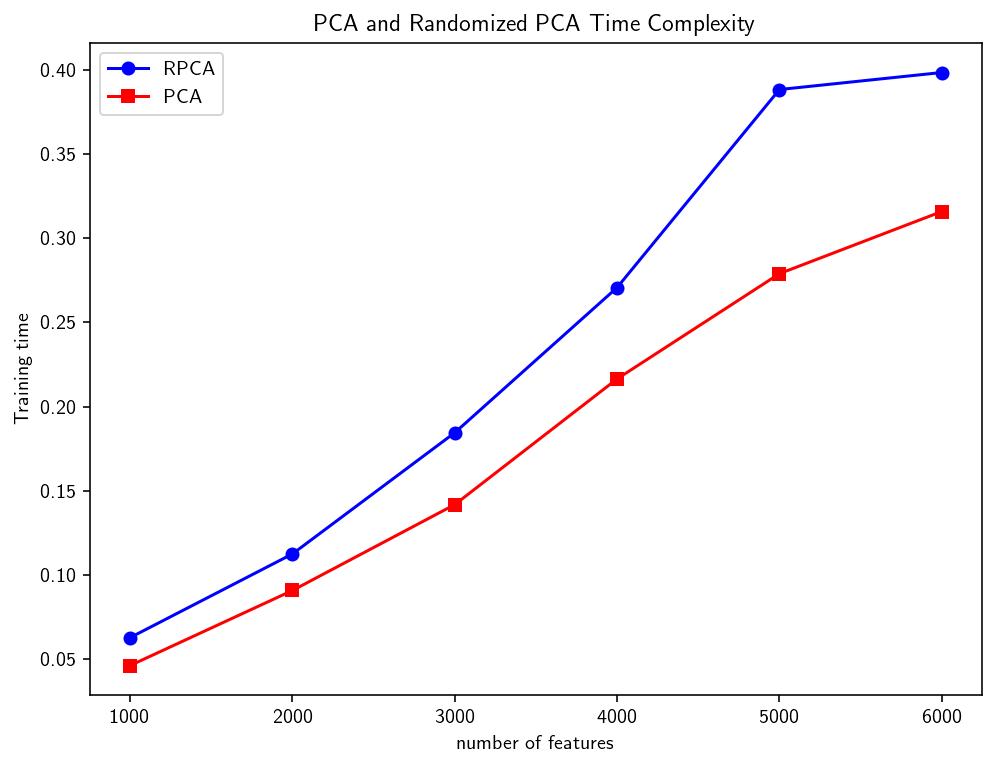

In [26]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("number of features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA Time Complexity")

### Kernel PCA

In [27]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [28]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

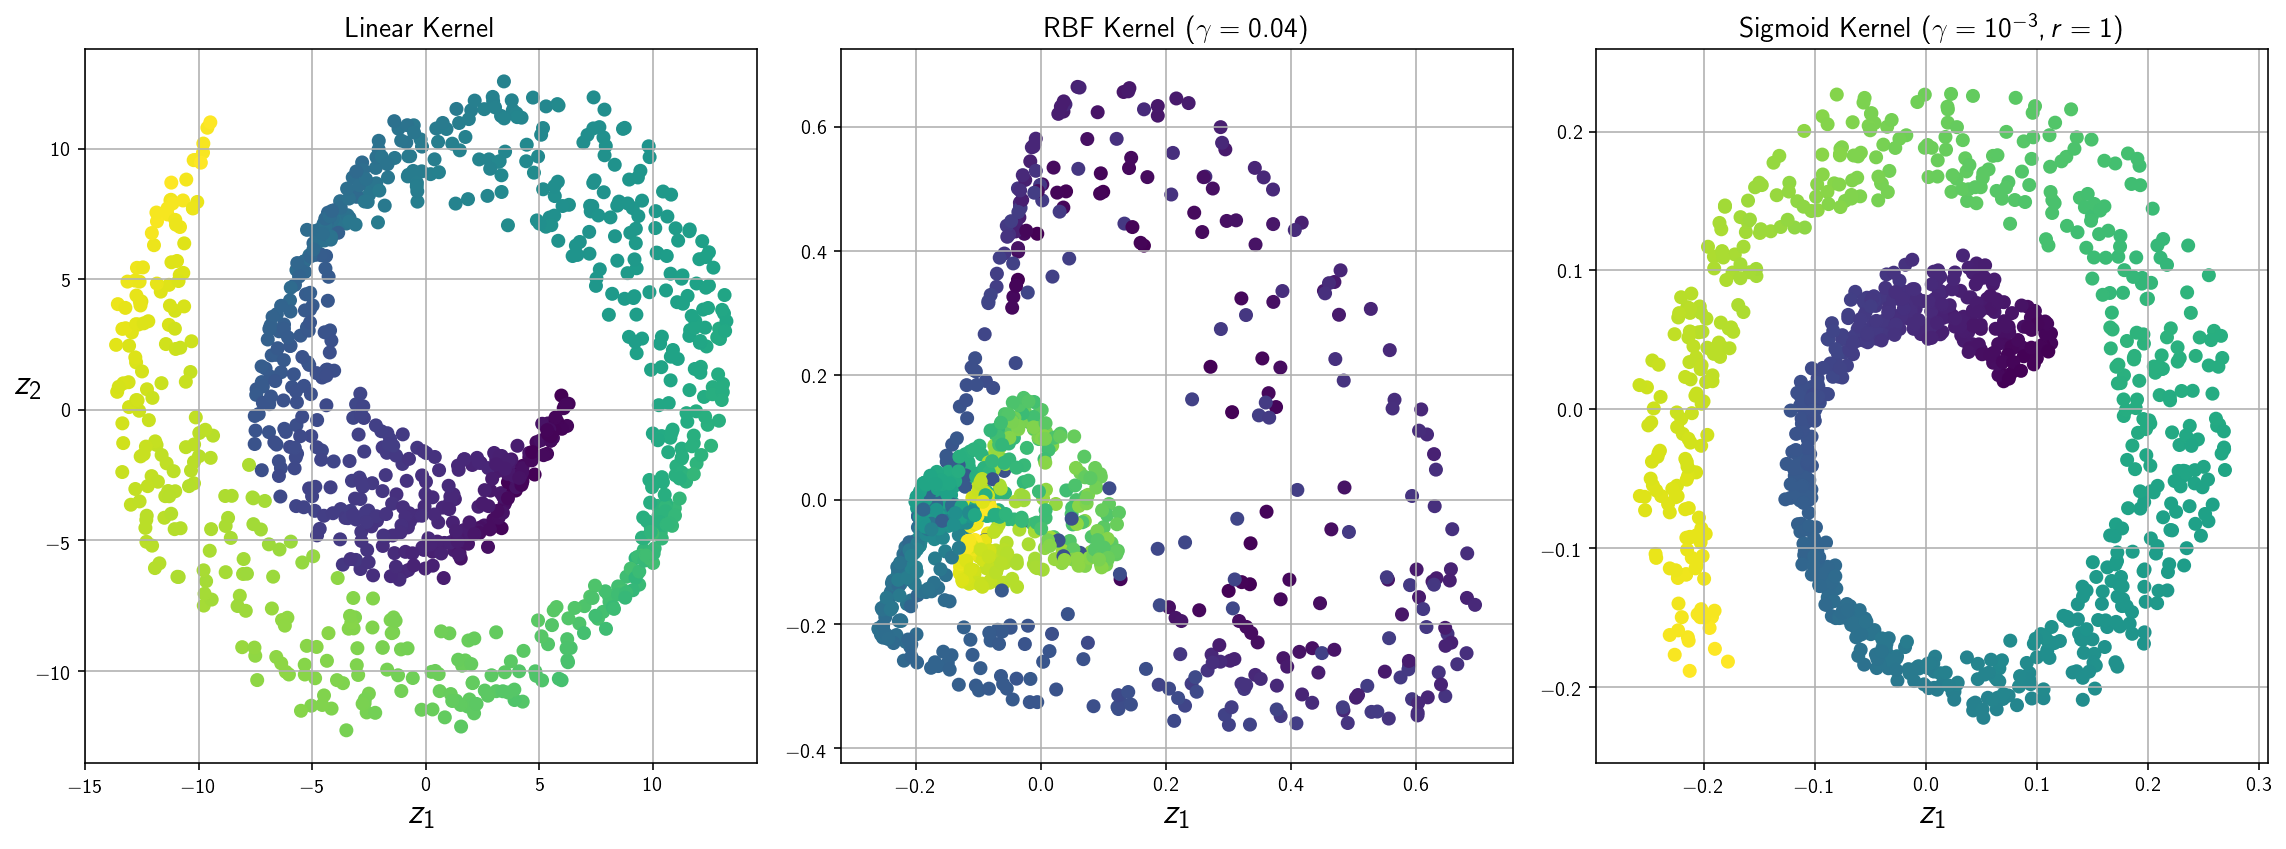

In [29]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(16, 6))
for subplot, pca, title in ((131, lin_pca, "Linear Kernel"), (132, rbf_pca, "RBF Kernel ($\gamma=0.04$)"), (133, sig_pca, "Sigmoid Kernel ($\gamma=10^{-3}, r=1$)")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)

    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.tight_layout()

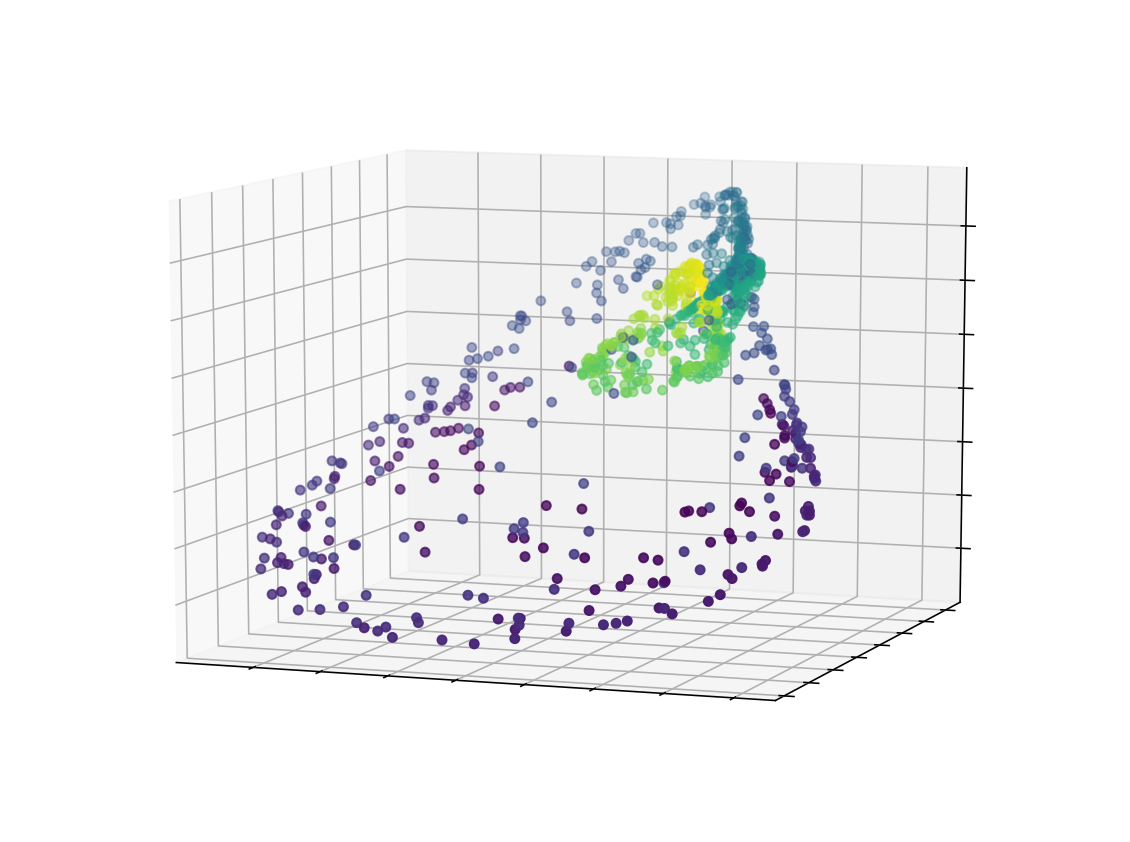

In [30]:
X_inverse = pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.tight_layout()

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([("kpca", KernelPCA(n_components=2)), ("log_reg", LogisticRegression())])
param_grid = [{"kpca__gamma": np.linspace(0.03, 0.05, 10),"kpca__kernel": ["rbf", "sigmoid"]}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([ 0.03   ,  0.03222,  0.03444,  0.03667,  0.03889,  0.04111,
        0.04333,  0.04556,  0.04778,  0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [33]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.786308795766125

### Locally Linear Embedding

In [35]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [36]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

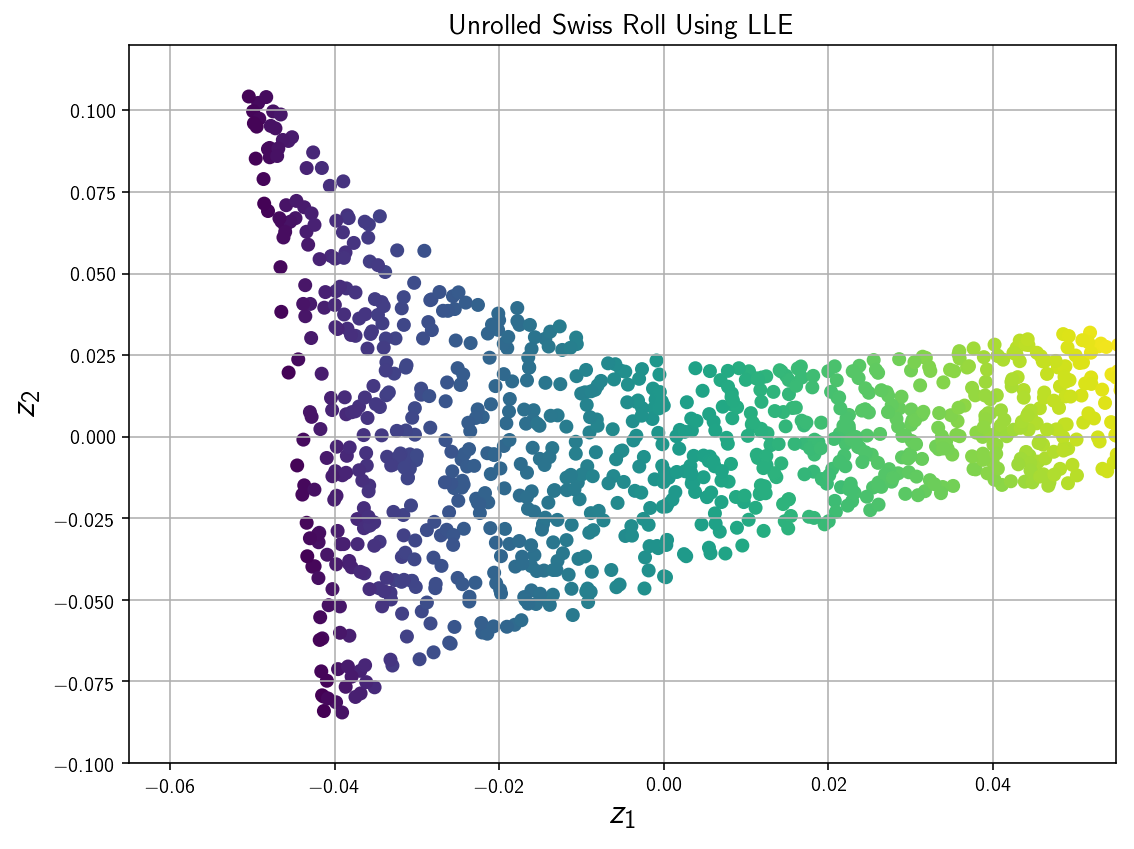

In [37]:
plt.title("Unrolled Swiss Roll Using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.tight_layout()

### MDS, Isomap and t-SNE

In [38]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [39]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

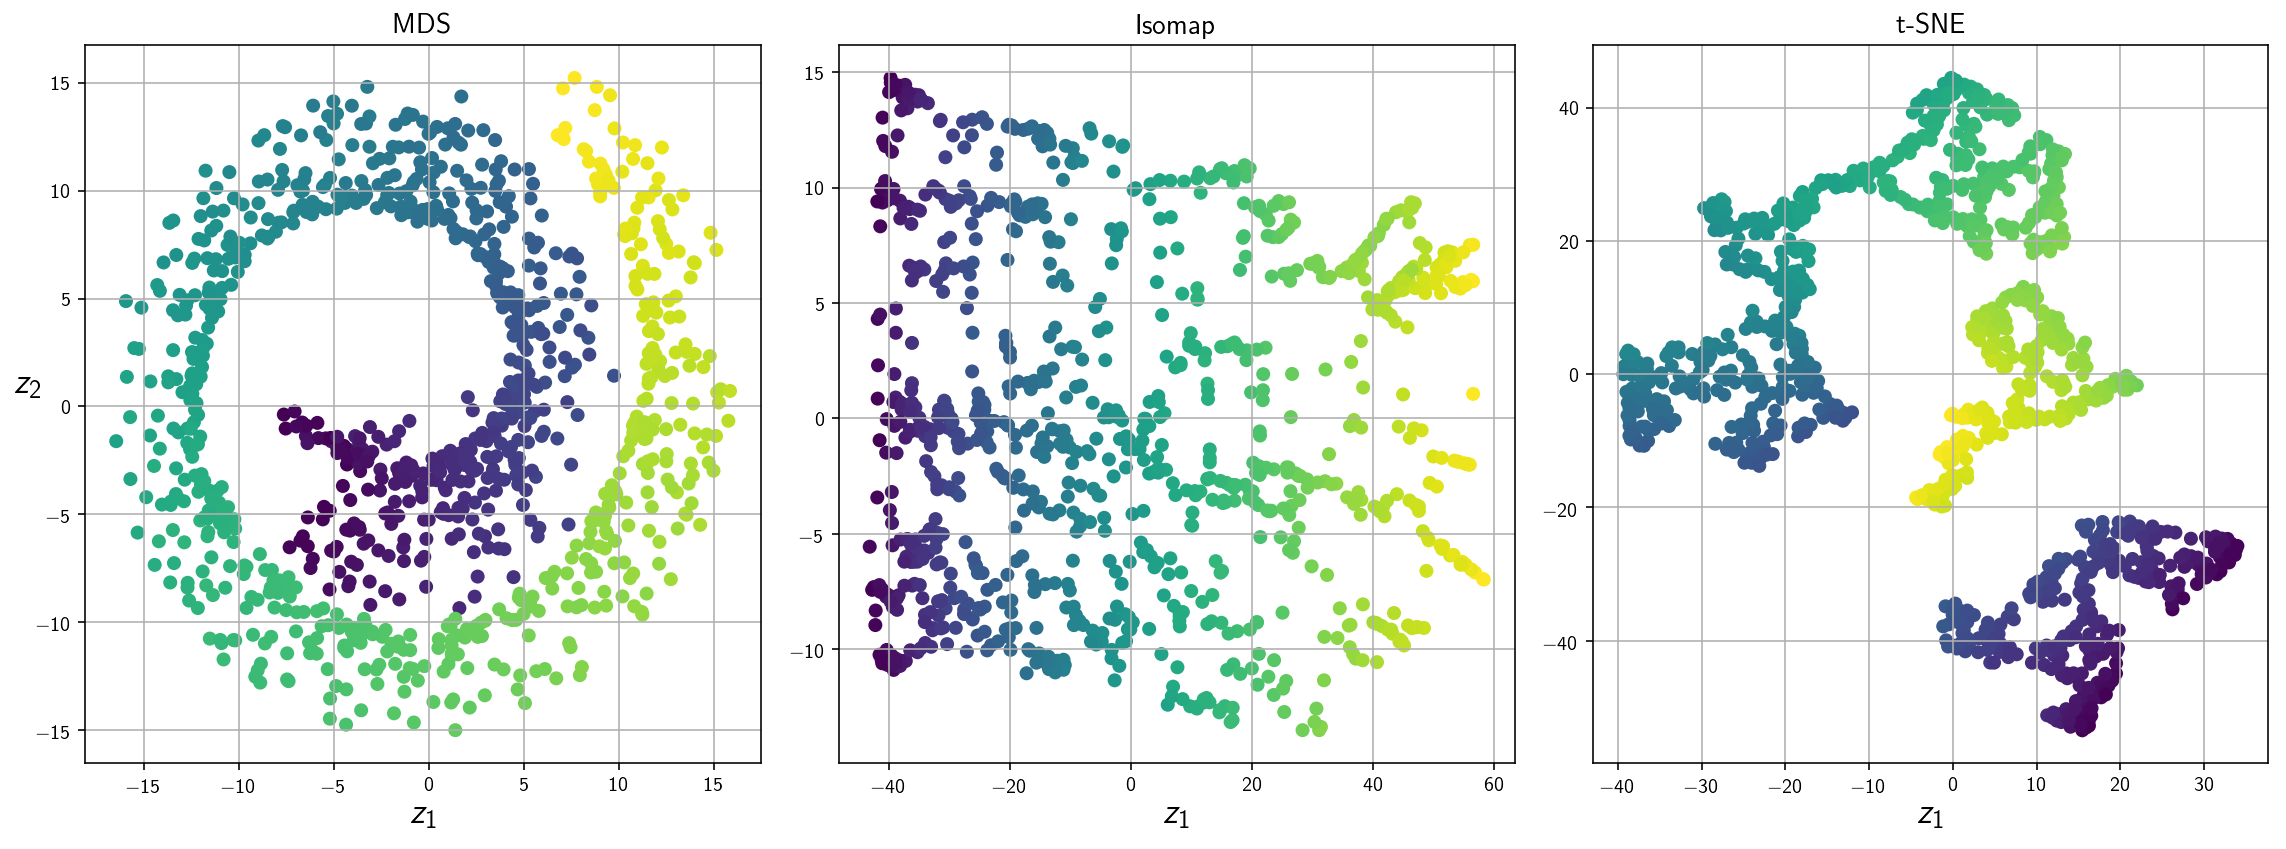

In [42]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(16, 6))

for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.tight_layout()

In [43]:
idx = np.random.permutation(60000)[:10000]
X, y = mnist['data'][idx], mnist['target'][idx]
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

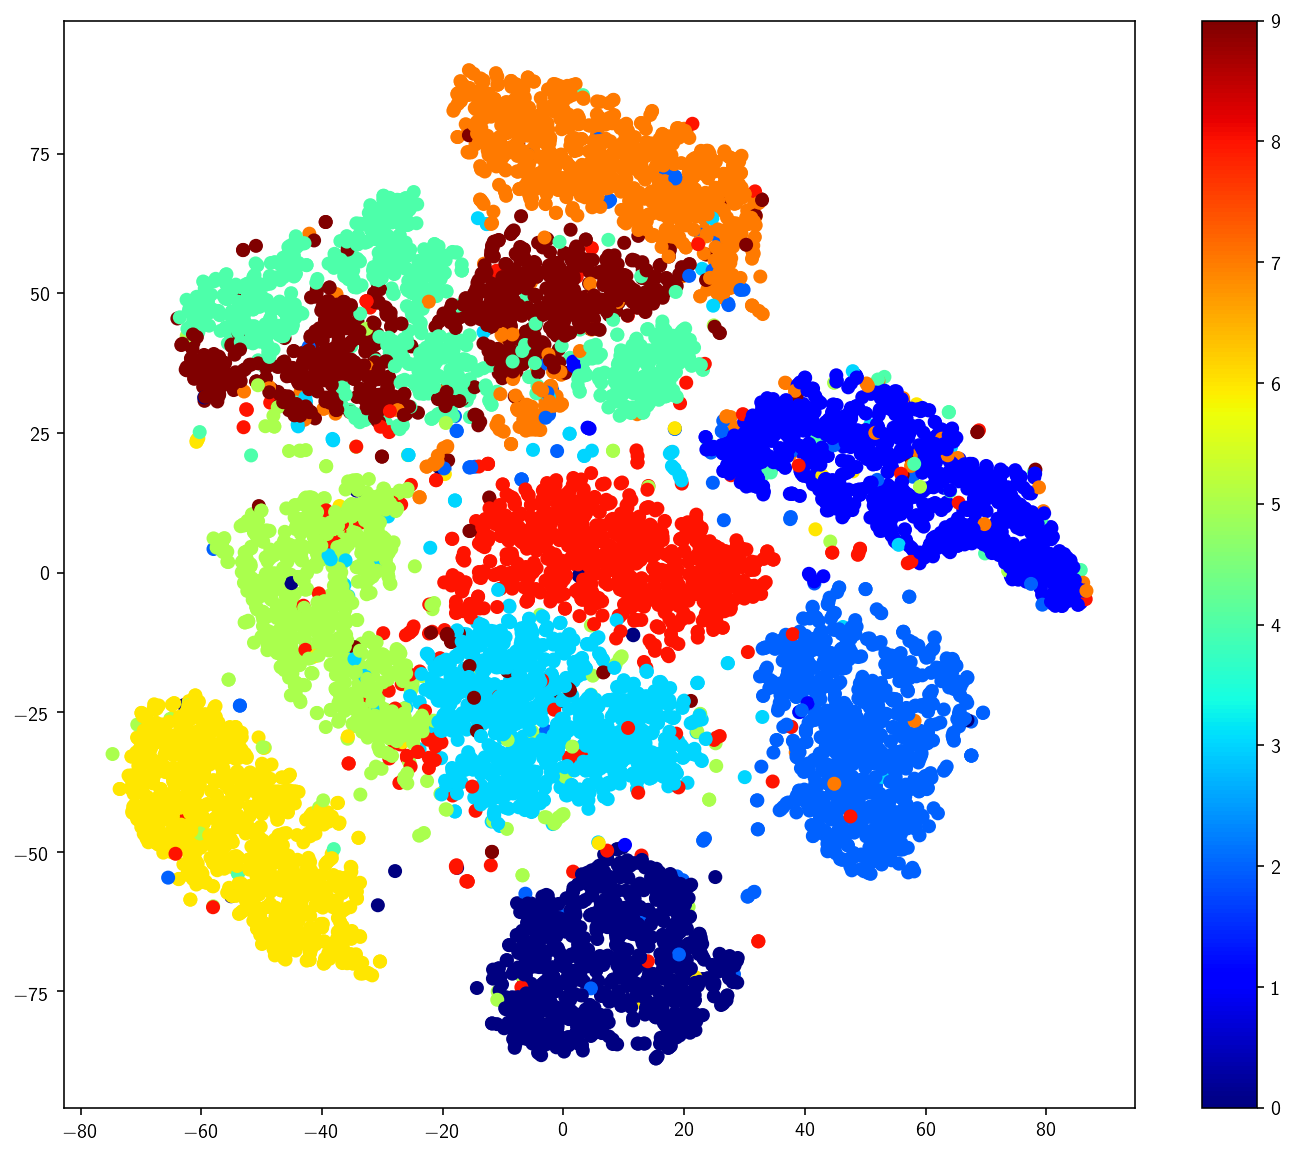

In [44]:
plt.figure(figsize=(12, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')
plt.colorbar();

In [45]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=cmap(digit / 9))
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

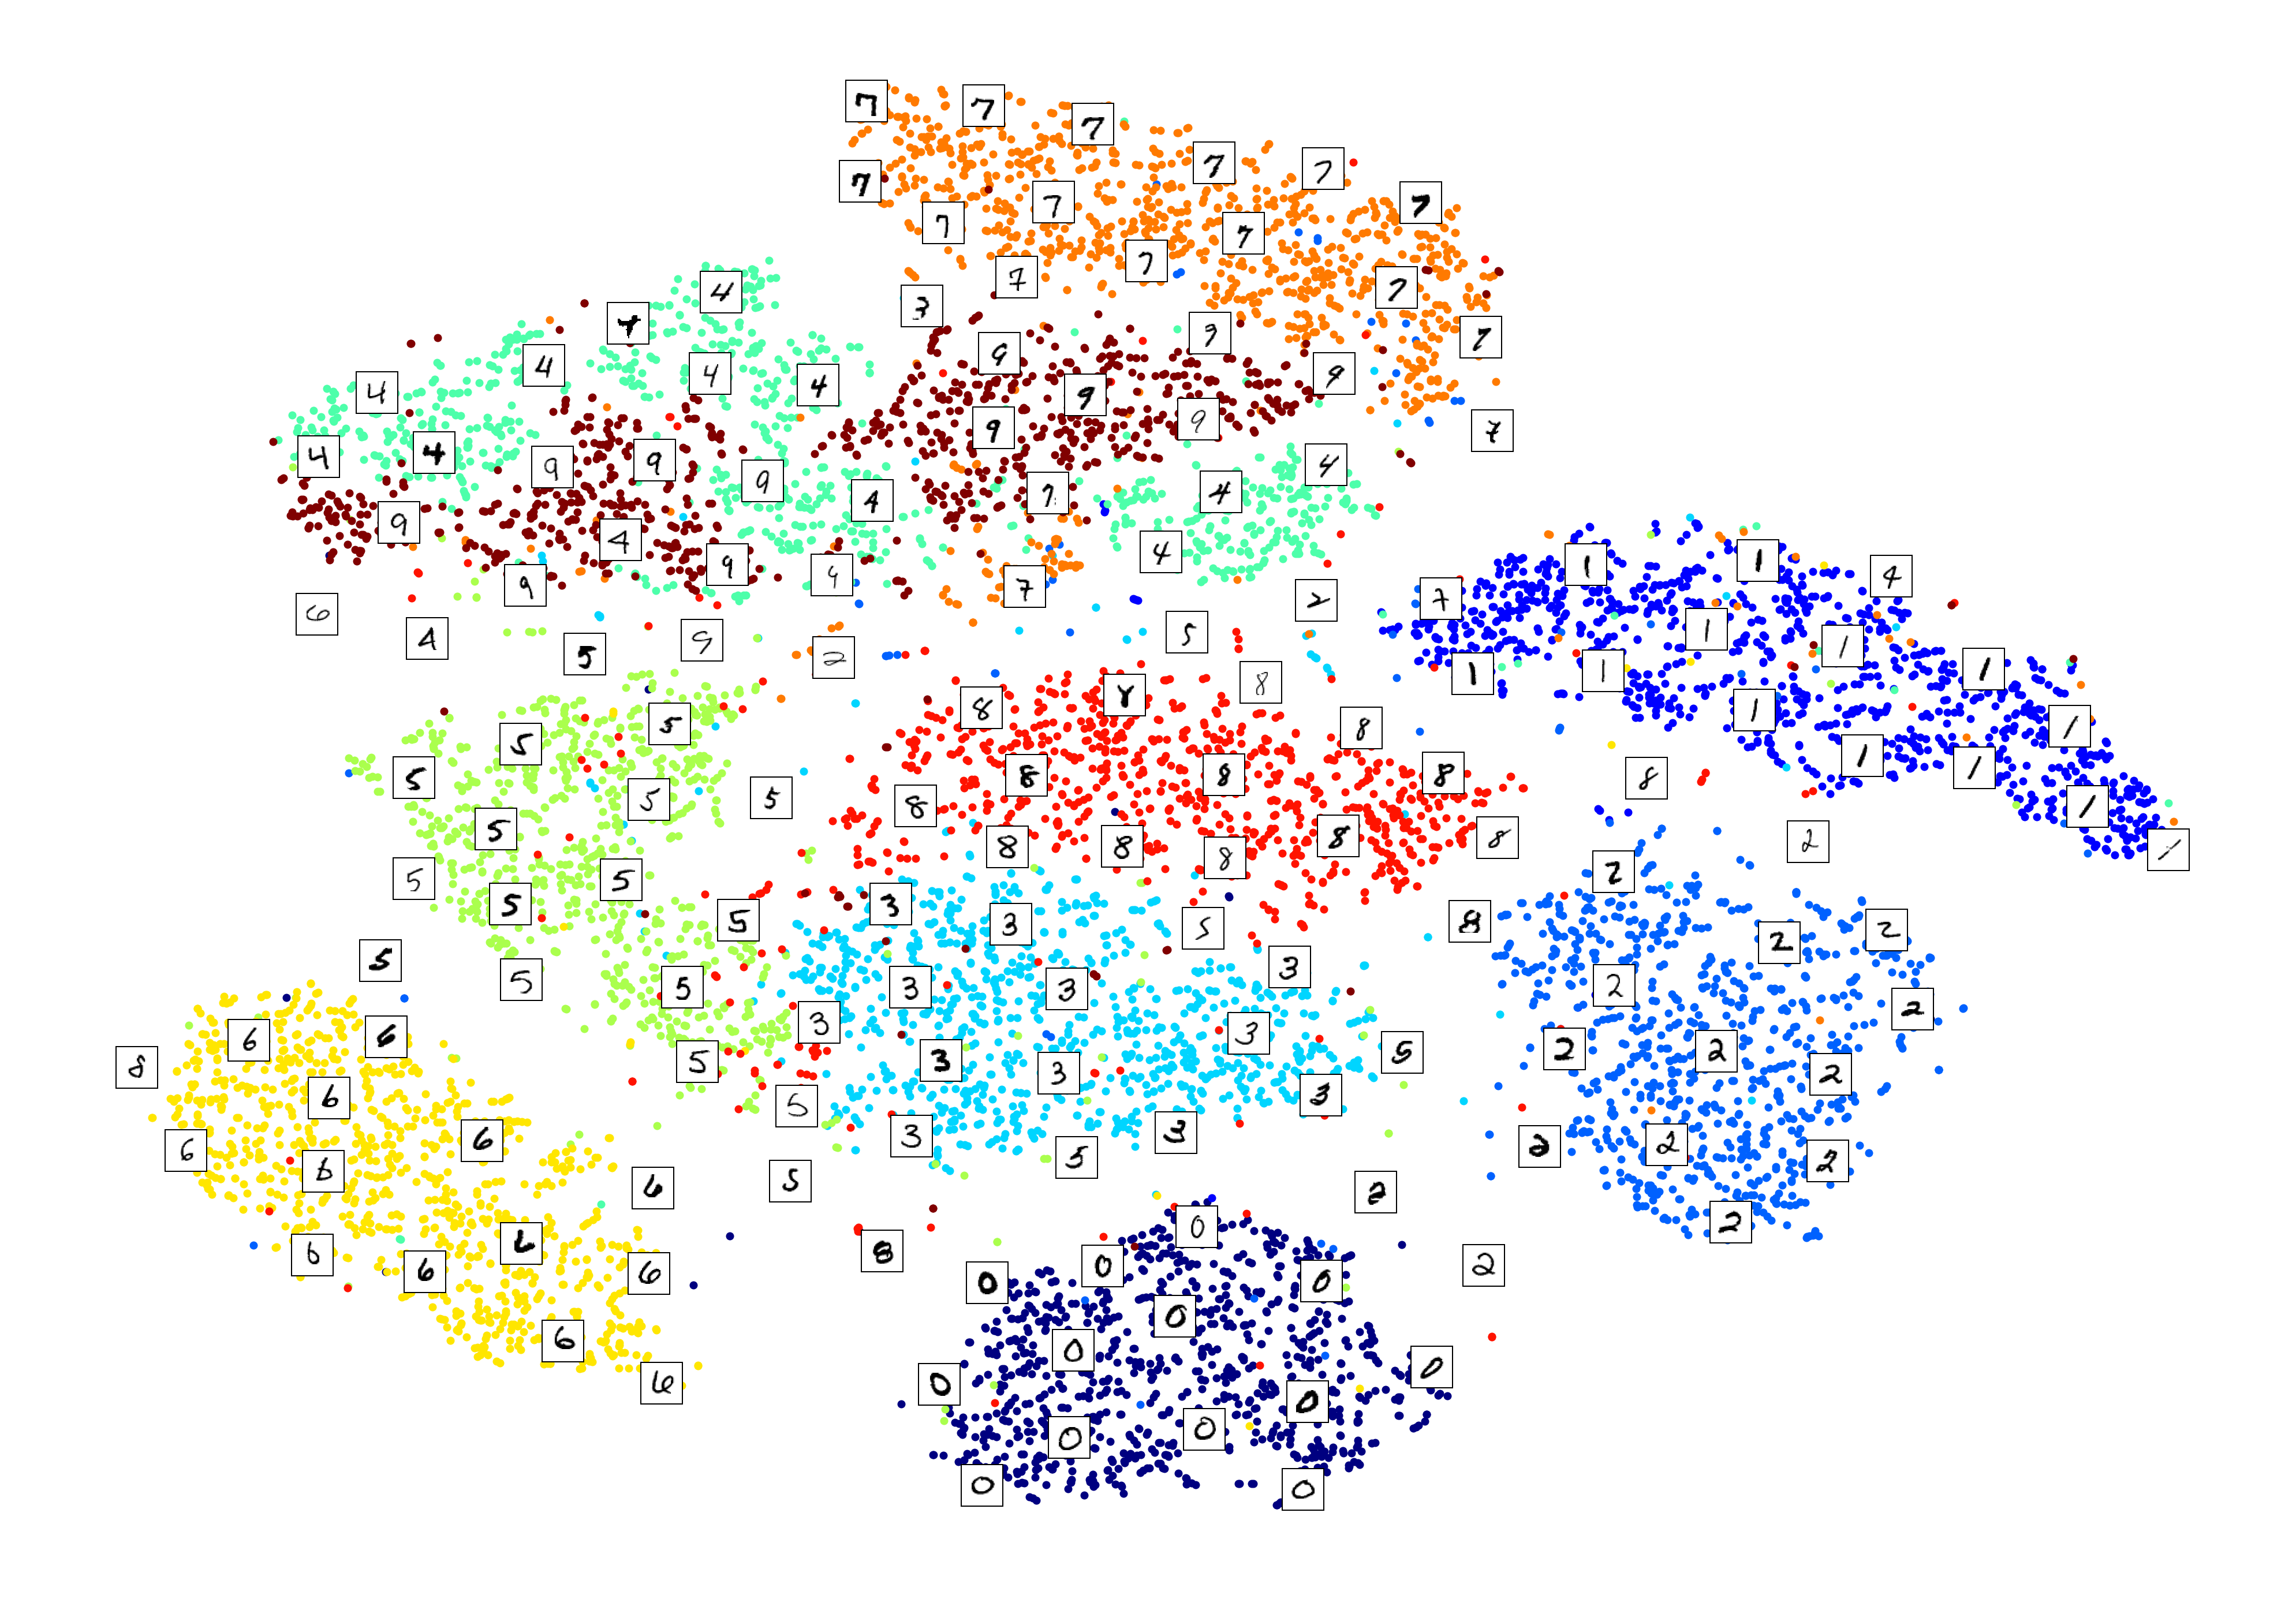

In [46]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

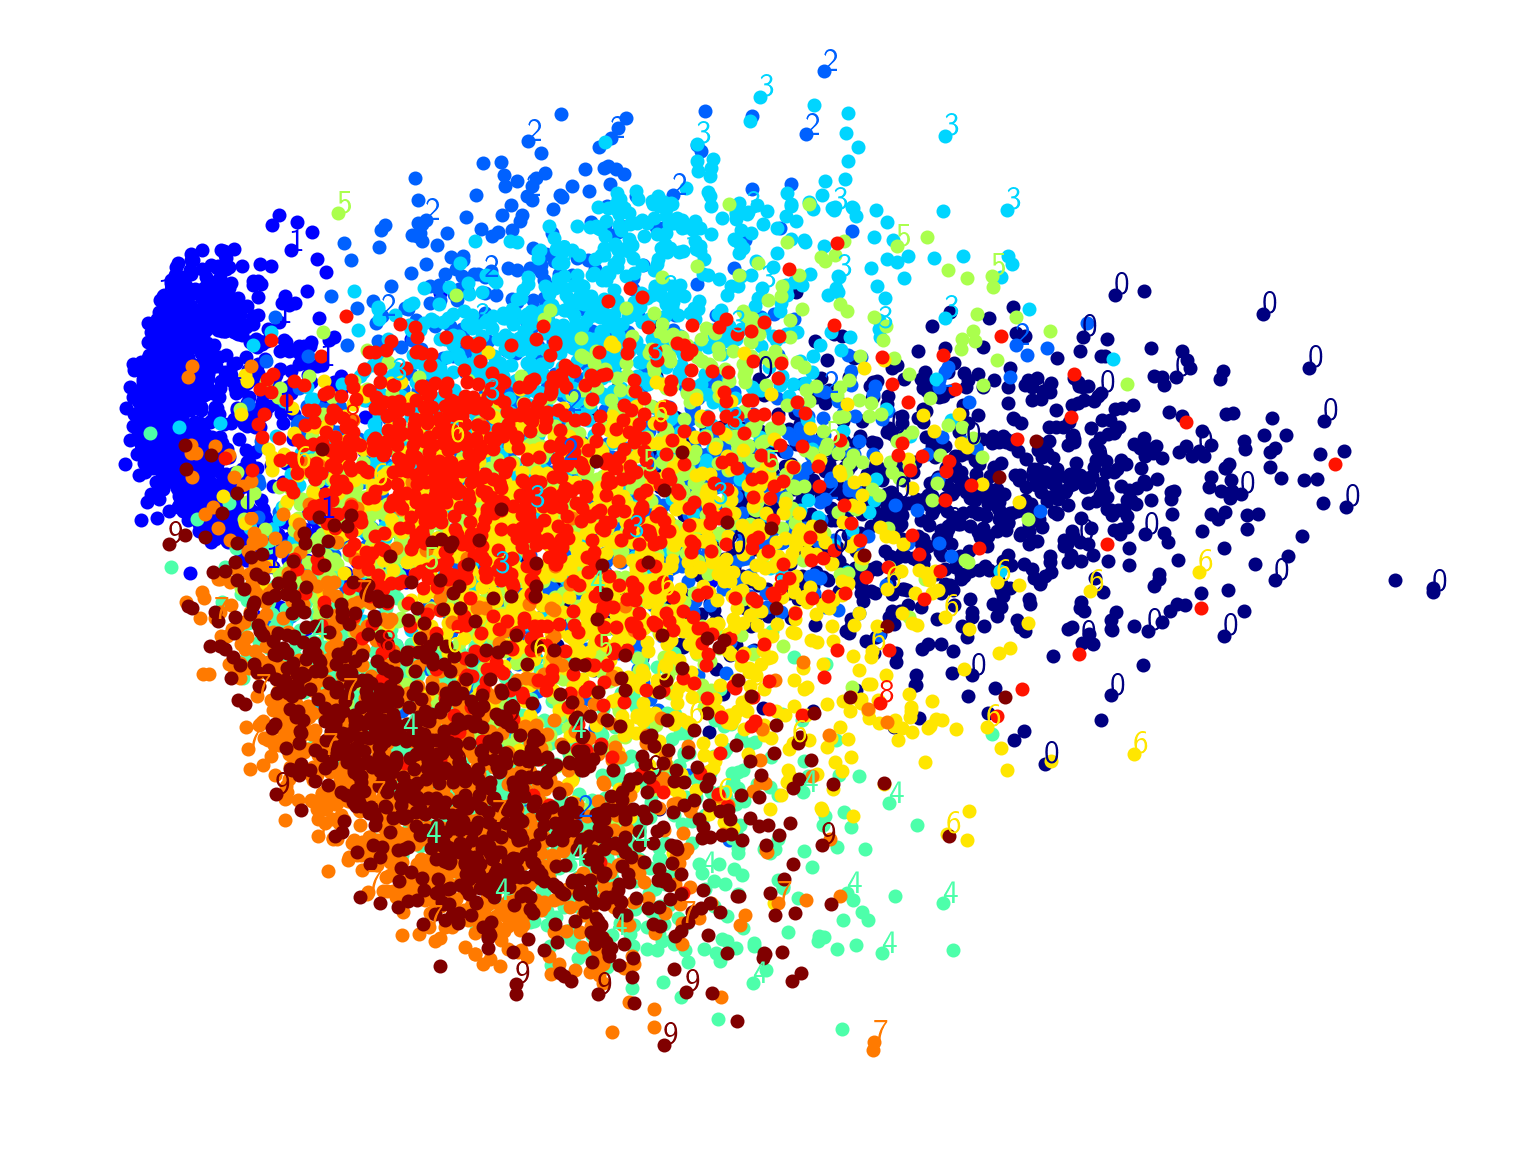

In [47]:
from sklearn.decomposition import PCA
import time

X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
plot_digits(X_pca_reduced, y)
plt.show()

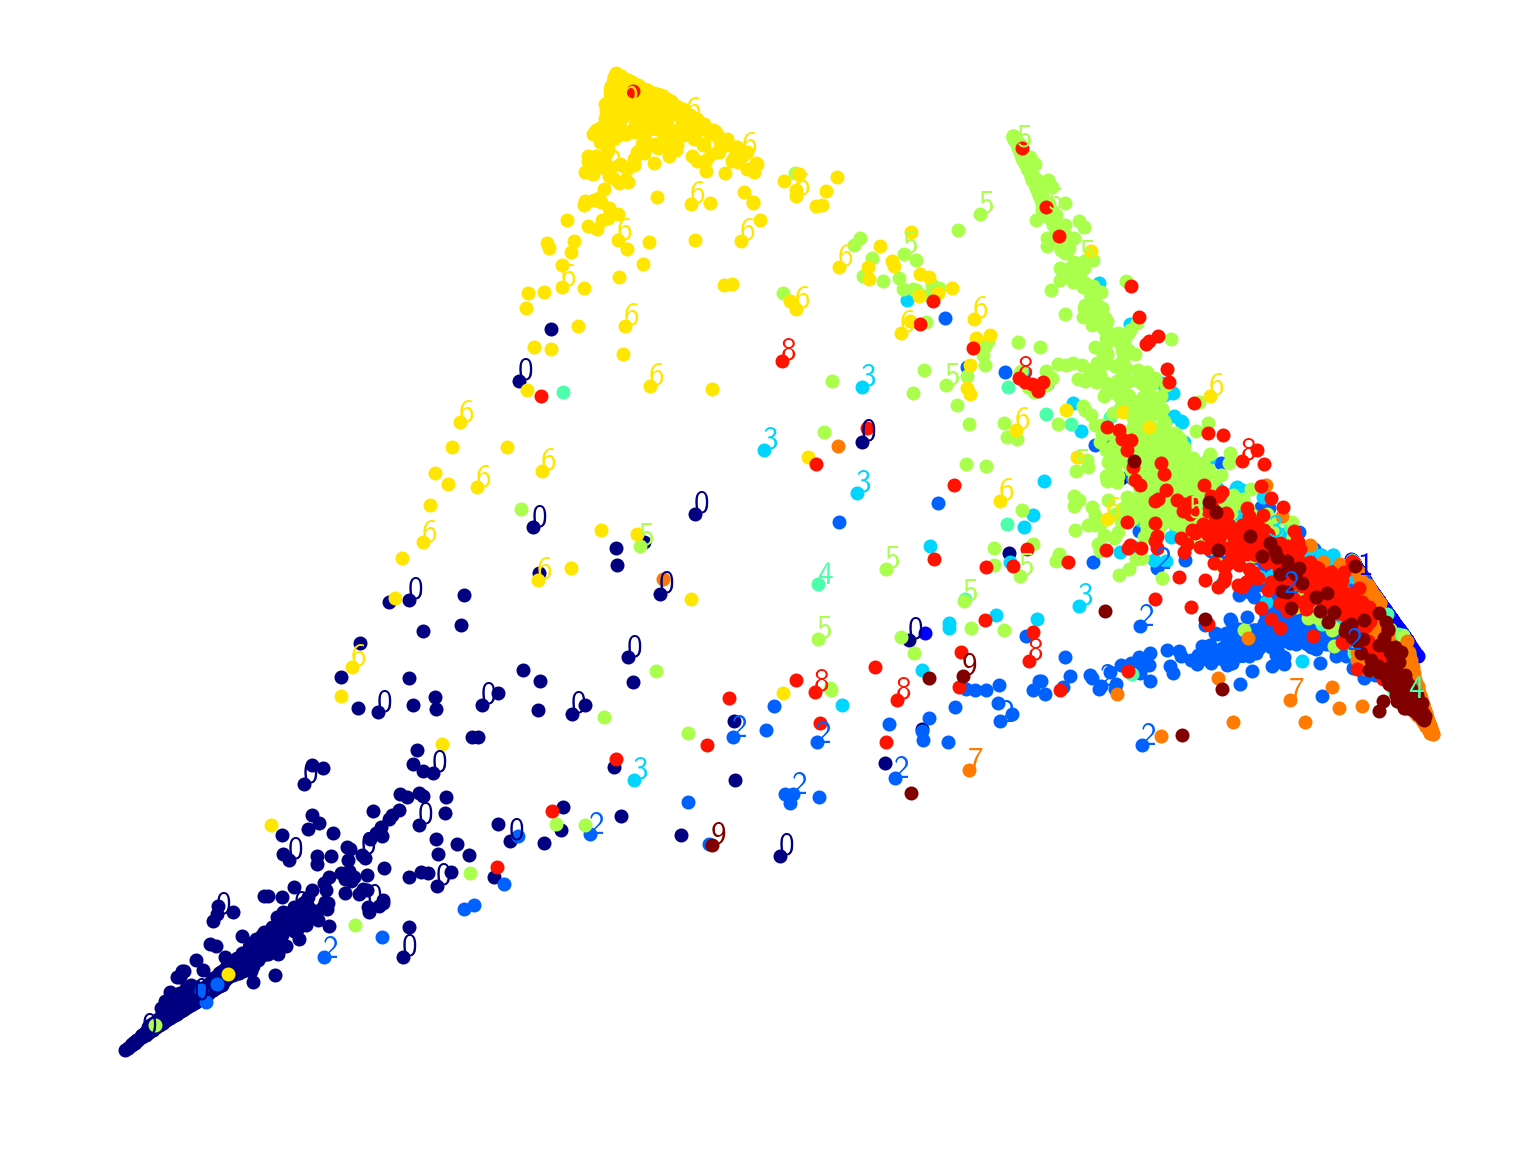

In [48]:
from sklearn.manifold import LocallyLinearEmbedding

X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
plot_digits(X_lle_reduced, y)
plt.show()

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())